# Medical expenses - Gradient Descent
This demo uses gradient descent to compute the best parameters for a linear model predicting medical expenses from age of the patient. Since we will be contrasting the standard formulation of gradient descent with both stochastic gradient descent (SGD) and Batch Gradient Descent (Batch-GD), we will make full use of the available data. This serves two functions. First, it will more clearly show the process of iteratively reducing loss. Second, GD, SGD and Batch_GD vary in how much data the consume and average for each parameter update. Working with larger amounts of data will make more clear how these mehods vary, and when one method is perhaps preferred over another. 

### Import

In [25]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

### Fonts

In [83]:
csfont = {'fontname':'Georgia'}
hfont = {'fontname':'Helvetica'}

### Load Data

In [26]:
data = pd.read_csv('../../data/healthcare_cost/insurance.csv')
columns = data.columns
x_raw = data.iloc[:,0].values
y_raw = data.iloc[:,-1].values

### Clean Dataset for the univariate example

In [27]:
ind0 = np.where(y_raw > 17000)[0]
ind1 = np.where(x_raw < 46)[0]
ind2 = np.where(y_raw > 10000)[0]
ind3 = np.intersect1d(ind1,ind2)
ind4 = np.union1d(ind3,ind0)
ind5 = range(x_raw.shape[0])
ind5 = np.setdiff1d(ind5,ind4)
x = x_raw[ind5].astype('float').copy()
y = y_raw[ind5].astype('float').copy()

### Normalize

In [28]:
mean_x = np.mean(x)
mean_y = np.mean(y)
x_norm = x / mean_x
y_norm = y / mean_y

### Add Column of ones

In [29]:
x_norm = np.expand_dims(x_norm,-1)
o = np.ones((x_norm.shape[0],1))
X_norm = np.hstack((x_norm,o))

### Divide Data
Dividing our data into training and testing data is a crucial step to prevent overfitting. Overfitting the data means our model becomes to specific to the data we used to train it. If the training data was a true representative sample of the data our model will encounter 'in the wild' when in production, this would not happen. However, training data rarely is truly representative. It is often small, carefully curated, and collected under experimental conditions where human decision making has led to the inclusion of some data, but not others. 

In [30]:
X_train = X_norm[:600,:].copy()
X_test = X_norm[600:,:].copy()
y_train = y_norm[:600].copy()
y_test = y_norm[600:].copy()

### Init
The learning rate represents how much to update the weights based on the computed gradients. Updating the weights too quickly and our model will jump erratically between different values for our parameters. Too slowly, and learning becomes slow and adds the risk of getting stuck in a local minimum: a solution that might appear optimal in its immediate surrounding, but is actually less optimal compared to other solutions further away. 

In [31]:
learning_rate = 0.01

### Gradient Descent
In traditional Gradient Descent we compute the gradient by taking into account all data point in our training data, before adjusting the parameters accordingly. This is what constrats it with both stochastic GD and batch GD. In Stochastic GD, we update our parameters from gradients estimated from a single data point in turn. Batch GD is compromise where we take a percentage of the data to compute the gradients on and update our parameters. traditional GD is stable but might get stuck. Stochastic GD updates to the weights are noise, since they are only based on a single data point at a time. Such big fluctuations can prevent GD from getting stuck in local minima. Batch GD usually provides a good intermediate regime in which we get both the stability of traditional GD and the explorative nature of SGD.<br>

Below is the entire gradient descent algorithm for linear regression, with each step commented. 

In [32]:
#Initialize the weight/parameters. We typically initialize our weights by picking them from a normal distribution, 
#centered on 0, with a relatively small variance.
w = np.random.randn((2)) * 0.01

#The number of epochs is the number of times we update our weights
no_epoch = 1000

#We initialize two empty lists to keep track of the loss and weights during training
w_history = []
loss_history = []

#Loop over all epochs
for epoch in range(no_epoch):

    #In the first step, we compute the current prediction y_pred, given our entire training dataset (X_train) 
    #and the current esrtimates for our weights (w). We can compute this very quickly and succicntly by taking the
    #dot product of training dataset with the weight, which yields an y_pred with the exact same dimnsionality as 
    # our actual outcome data (y_train).
    y_pred = np.dot(X_train,w)
    
    #We compute the error between what we predicted (y_pred) and the actual outcome (y_train). The better our
    #weights become, the less our predictions deviate from the actual outcomes (small error). 
    E = (y_train - y_pred)

    #We combine the error of each prediction (y_pred_i) and actual outcome (y_train_i) by squaring their error 
    #and summing the resulting values together. The resulting value will be 0 or positive, since we apply a squaring operation.
    #The smaller the loss, the better the estimated weihts help our model predicting the actual outcome y_train. 
    loss = np.sum(E**2)

    #Store for plotting later
    loss_history.append(loss)
    w_history.append(w)

    #We compute the gradient as the dot product between our training data X_train and the associated 
    #error E computed in the previous step. This is normalized by 1/2 times the number of data points
    gradient = np.dot(X_train.T,E) * (-2/X_train.shape[0])
    
    #Multipliyng the average gradinet across data points with the learning rate gives us the delta: the amount
    #we need to change each weight to descent down the gradient and improve our algorithms prediction. 
    delta = gradient * learning_rate
    w = w - delta

### Plot Loss

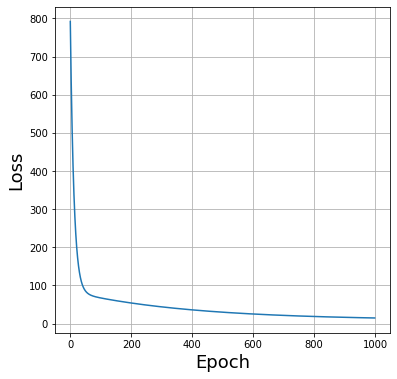

In [33]:
loss_history = np.array(loss_history)
plt.figure(figsize=(6,6));
plt.plot(loss_history)
plt.grid();
plt.xlabel('Epoch',fontsize=18);
plt.ylabel('Loss',fontsize=18);

### Examine the weights
Comparing our result to the parameters we found using the statistical approach and OLS, it appears as if we have drastically different values. They are different, but only because in this example, the input data was first normalized. If we look at the resulting fit, we see that we have a model quite similar to that fitted before. 

In [35]:
a = w[0]
b = w[1]
print(a,b)
x0 = 0.25
x1 = 1.75
y0 = w[0]*x0 + w[1]
y1 = w[0]*x1 + w[1]

1.2379322568680067 -0.21569199553338617


### Plot

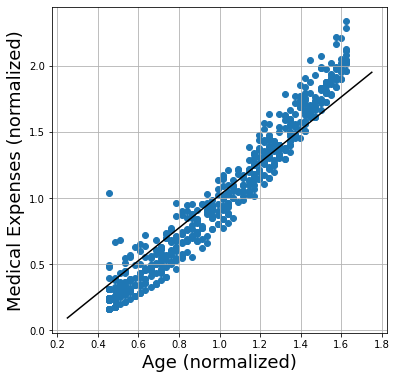

In [36]:
plt.figure(figsize=(6,6));
plt.scatter(X_train[:,0],y_train);
plt.plot([x0,x1],[y0,y1],'k',zorder=100);
plt.grid();
plt.xlabel('Age (normalized)',fontsize=18);
plt.ylabel('Medical Expenses (normalized)',fontsize=18);

### Gradient Descent as a function to quickly perform training over a nmber of different starting positions

In [77]:
def gradient_descent(w):

    no_epoch = 2000
    w_history = []
    loss_history = []
    for epoch in range(no_epoch):
        y_pred = np.dot(X_train,w)
        E = (y_train - y_pred)
        loss = np.sum(E**2)
        loss_history.append(loss)
        w_history.append(w)
        gradient = np.dot(X_train.T,E) * (-2/X_train.shape[0])
        delta = gradient * learning_rate
        w = w - delta

    #Return
    return w, w_history, loss_history

### GD for different starting conditions

In [100]:
xval = np.sin(np.linspace(0,np.pi*2,21)[::-1]) * 1.5
yval = np.cos(np.linspace(0,np.pi*2,21)[::-1]) * 1.5
w_histories = []
loss_histories = []
for i in range(len(xval)):
    w, w_history, loss_history = gradient_descent([xval[i],yval[i]])
    w_histories.append(np.array(w_history))
    loss_histories.append(np.array(loss_history))
w_histories = np.array(w_histories)
loss_histories = np.array(loss_histories)

### Plot Loss Field
An interesting visualization is the loss field and the path our weights took during learning. The loss field is a representation of where the loss is minial, given a range of values for our weights. 

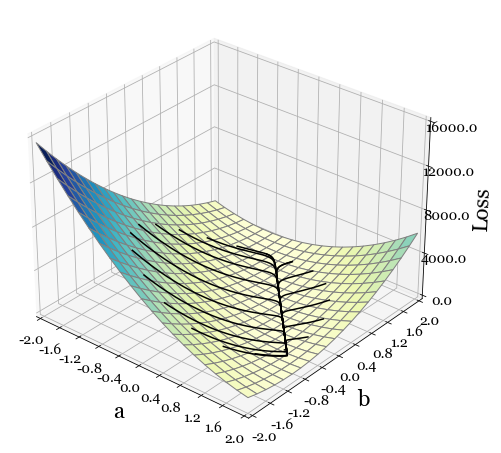

In [101]:
aval = np.linspace(-2,2,21)
bval = np.linspace(-2,2,21)
Xm,Ym = np.meshgrid(aval, bval)
XX = np.array([Xm.ravel(), Ym.ravel()]).T
lossfield = np.zeros((21,21)).T
for i in range(len(aval)):
    for j in range(len(bval)):
        w = np.array([aval[i],bval[j]])
        w = np.expand_dims(w,-1)
        y_pred = np.dot(X_train,w)
        E = (y_train - y_pred)
        loss = np.sum(E**2) / X_train.shape[0]
        lossfield[j,i] = loss
plt.figure(figsize=(8,8))
ax = plt.axes(projection='3d')
ax.plot_surface(Xm,Ym,lossfield,cmap='YlGnBu', edgecolor='gray')
ax.view_init(elev=30., azim=310)

for m in range(w_histories.shape[0]):
    w_history = w_histories[m,:,:]
    loss_history = loss_histories[m,:]
    ax.plot(w_history[:,0],w_history[:,1],loss_history,zorder=100,c='k')
plt.axis((-2,2,-2,2))

ax.set_xticks(np.linspace(-2,2,11),labels=np.round(np.linspace(-2,2,11),2),fontsize=14,**csfont);
ax.set_yticks(np.linspace(-2,2,11),labels=np.round(np.linspace(-2,2,11),2),fontsize=14,**csfont);
ax.set_zticks(np.linspace(0,16000,5),labels=np.linspace(0,16000,5),fontsize=14,**csfont);
ax.set_xlabel('\na',fontsize=22,**csfont);
ax.set_ylabel('\nb',fontsize=22,**csfont);
ax.set_zlabel('\nLoss',fontsize=22,**csfont);
plt.savefig('../../assets/figures/014/19.png', bbox_inches="tight")

### 2D Plot

[ 1.37280848 -0.35982307]
[ 1.35864086 -0.34468331]
[ 1.35163295 -0.33719453]
[ 1.35247072 -0.33808979]
[ 1.36107218 -0.34728145]
[ 1.37659534 -0.36386978]
[ 1.3975207  -0.38623098]
[ 1.42179994 -0.4121762 ]
[ 1.44705643 -0.43916572]
[ 1.4708179  -0.46455763]
[ 1.4907584 -0.4858664]
[ 1.50492601 -0.50100616]
[ 1.51193393 -0.50849494]
[ 1.51109616 -0.50759968]
[ 1.5024947  -0.49840802]
[ 1.48697153 -0.48181969]
[ 1.46604617 -0.45945849]
[ 1.44176693 -0.43351327]
[ 1.41651044 -0.40652375]
[ 1.39274898 -0.38113183]
[ 1.37280848 -0.35982307]


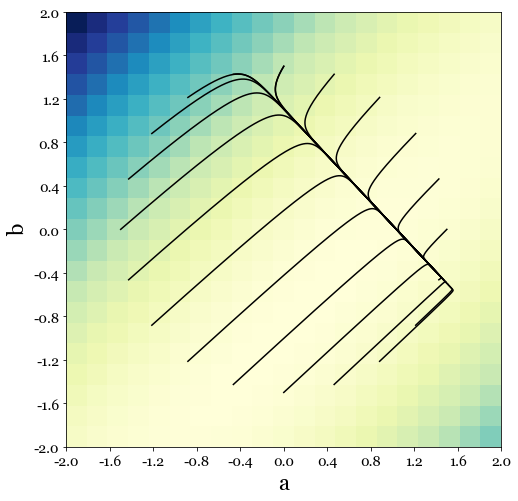

In [102]:
aval = np.linspace(-2,2,21)
bval = np.linspace(-2,2,21)
Xm,Ym = np.meshgrid(aval, bval)
XX = np.array([Xm.ravel(), Ym.ravel()]).T
lossfield = np.zeros((21,21)).T
for i in range(len(aval)):
    for j in range(len(bval)):
        w = np.array([aval[i],bval[j]])
        w = np.expand_dims(w,-1)
        y_pred = np.dot(X_train,w)
        E = (y_train - y_pred)
        loss = np.sum(E**2) / X_train.shape[0]
        lossfield[j,i] = loss
plt.figure(figsize=(8,8))
plt.imshow(lossfield,cmap='YlGnBu',extent=(-2,2,-2,2));
for m in range(w_histories.shape[0]):
    w_history = w_histories[m,:,:]
    print(w_history[-1,:])
    plt.plot(w_history[:,0],w_history[:,1],zorder=100,c='k')
plt.xticks(np.linspace(-2,2,11),labels=np.round(np.linspace(-2,2,11),2),fontsize=14,**csfont);
plt.yticks(np.linspace(-2,2,11),labels=np.round(np.linspace(-2,2,11),2),fontsize=14,**csfont);
plt.xlabel('a',fontsize=22,**csfont);
plt.ylabel('b',fontsize=22,**csfont);
plt.savefig('../../assets/figures/014/19.png', bbox_inches="tight")